<a href="https://colab.research.google.com/github/gollum-98/Neural-Network-Time-Series-prediction/blob/master/Stock%20prices%20-%20TATAMOTORS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time,series,start=0,end=None,format="-"):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('days')
  plt.ylabel('closing price')
  plt.grid(True)

In [3]:
import csv

In [5]:
days = []
prices = []
i=0
with open('../content/TATAMOTORS.NS (1).csv') as csvfile:
  reader = csv.reader(csvfile,delimiter=',')
  next(reader)
  for row in reader:
    days.append(i)
    price = row[5]
    if price == 'null':
      price = prices[i-1]
    prices.append(float(price))
    i+=1

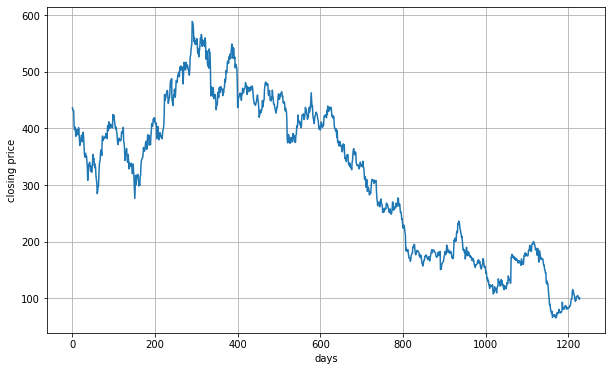

In [6]:
series = np.array(prices)
time = np.array(days)
plt.figure(figsize=(10,6))
plot_series(time,series)

In [7]:
split_time = 1000
x_train = series[:split_time]
time_train = time[:split_time]
x_val = series[split_time:]
time_val = time[split_time:]

In [8]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  series = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w : w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w : (w[:-1],w[1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

In [9]:
def predict_model(model,series,window_size):
  series = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift = 1,drop_remainder=True)
  ds = ds.flat_map(lambda w : w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  return model.predict(ds)

In [10]:
tf.keras.backend.clear_session()
window_size = 30
batch_size = 64
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=256)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)
Epoch 1/100
16/16 [==============================] - 1s 48ms/step - loss: 422.0019 - mae: 422.5018 - lr: 1.0000e-08
Epoch 2/100
16/16 [==============================] - 1s 46ms/step - loss: 416.4522 - mae: 416.9523 - lr: 1.1220e-08
Epoch 3/100
16/16 [==============================] - 1s 45ms/step - loss: 409.6189 - mae: 410.1189 - lr: 1.2589e-08
Epoch 4/100
16/16 [==============================] - 1s 46ms/step - loss: 402.9622 - mae: 403.4621 - lr: 1.4125e-08
Epoch 5/100
16/16 [==============================] - 1s 48ms/step - loss: 395.6519 - mae: 396.1519 - lr: 1.5849e-08
Epoch 6/100
16/16 [==============================] - 1s 46ms/step - loss: 386.0958 - mae: 386.5958 - lr: 1.7783e-08
Epoch 7/100
16/16 [==============================] - 1s 47ms/step - loss: 381.8118 - mae: 382.3118 - lr: 1.9953e-08
Epoch 8/100
16/16 [==============================] - 1s 47ms/step - loss: 378.7984 - m

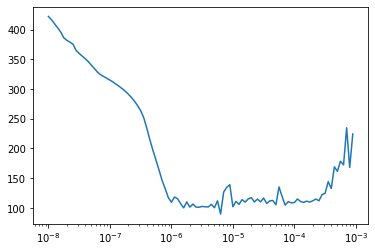

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
window_size = 15
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=1000)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
 #   lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)
Epoch 1/200
31/31 [==============================] - 1s 35ms/step - loss: 265.7252 - mae: 266.2250
Epoch 2/200
31/31 [==============================] - 1s 35ms/step - loss: 134.0351 - mae: 134.5343
Epoch 3/200
31/31 [==============================] - 1s 36ms/step - loss: 113.4202 - mae: 113.9191
Epoch 4/200
31/31 [==============================] - 1s 36ms/step - loss: 104.5337 - mae: 105.0326
Epoch 5/200
31/31 [==============================] - 1s 35ms/step - loss: 99.6364 - mae: 100.1352
Epoch 6/200
31/31 [==============================] - 1s 35ms/step - loss: 94.0191 - mae: 94.5179
Epoch 7/200
31/31 [==============================] - 1s 35ms/step - loss: 89.1407 - mae: 89.6392
Epoch 8/200
31/31 [==============================] - 1s 36ms/step - loss: 84.2282 - mae: 84.7267
Epoch 9/200
31/31 [==============================] - 1s 35ms/step - loss: 81.0636 - mae: 81.5621
Epoch 10/200
31/

In [19]:
forecast = predict_model(model,series,window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

In [20]:
print(forecast[:10])

[152.90265 150.09299 144.59918 144.92729 141.19336 137.12794 136.64124
 134.73589 131.92575 124.02109]


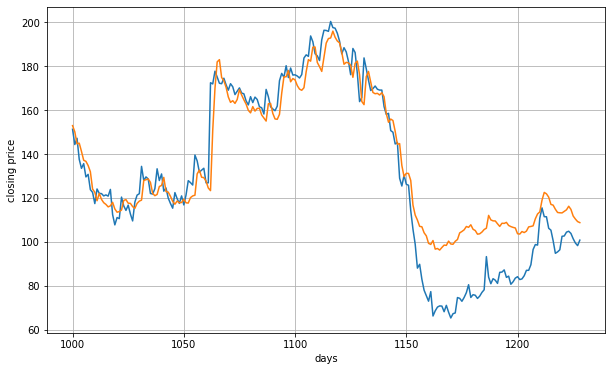

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, forecast)

In [22]:
print(tf.keras.metrics.mean_absolute_error(x_val,forecast))

tf.Tensor(10.578932, shape=(), dtype=float32)
